# How Developers Learn to Code: An Analysis Using Stack Overflow Survey Data

This project explores how developers acquire their coding skills and how different learning paths relate to experience, age, and salary.  
Using the Stack Overflow Developer Survey, we examine:

- The most common learning methods and combinations.
- Popular online resources for learning.
- Patterns across different age groups and experience levels.
- The relationship between learning strategies and salary outcomes.

Each section builds on data cleaning, feature engineering, and statistical modeling to uncover insights into modern developer education.


## Step 0: Setup and Data Import

We begin by importing necessary libraries for data analysis, visualization, and modeling.

Then we load the Stack Overflow Developer Survey dataset to begin our analysis.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
dev = pd.read_csv('survey_results_public.csv')

## Step 1: Understanding How Developers Learn to Code

The `LearnCode` column contains each respondent's selected learning methods (e.g. "Online courses", "University", "Books"), often with multiple selections per person.

In this step:
- We split and clean these multi-choice responses.
- Convert them into a structured multi-label format (multi-hot encoding).
- Analyze:
  - The percentage of developers using each method.
  - How often each method is used **on its own** versus **in combination** with others.

This helps us understand not only what developers rely on, but how they mix and match resources.


,Selected (%),Selected Alone (%),Selected With Others (%)
"Other online resources (e.g., videos, blogs, forum, online community)",82.09,6.07,76.02
Books / Physical media,50.24,0.85,49.39
Online Courses or Certification,50.04,0.81,49.23
"School (i.e., University, College, etc)",49.14,2.37,46.77
On the job training,45.04,0.51,44.53
Colleague,23.57,0.15,23.42
Coding Bootcamp,10.75,0.25,10.50
Friend or family member,10.54,0.10,10.44
Other (please specify):,6.01,0.73,5.28


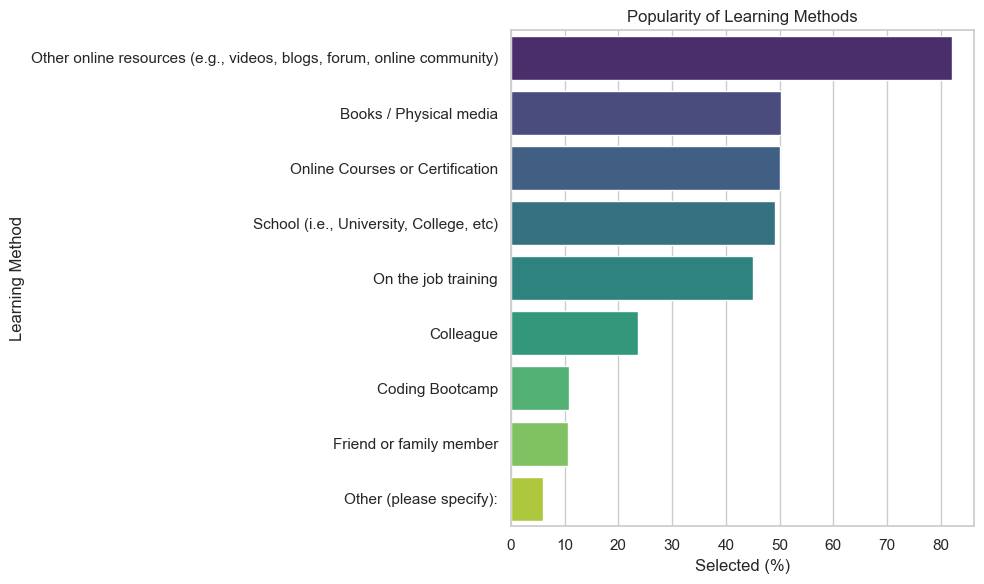

In [13]:
# Step 1: Clean and split LearnCode
df_clean = dev.dropna(subset=["LearnCode"]).copy()
df_clean["LearnCodeList"] = df_clean["LearnCode"].str.split(";").apply(lambda lst: [x.strip() for x in lst])

# Step 2: Create multi-hot encoded DataFrame

mlb = MultiLabelBinarizer()
multi_hot = pd.DataFrame(mlb.fit_transform(df_clean["LearnCodeList"]), 
                         columns=mlb.classes_, 
                         index=df_clean.index)

# Step 3: Combine with original DataFrame
df_combined = pd.concat([df_clean[["ResponseId"]], multi_hot], axis=1)

# Step 4: Total number of respondents
total_respondents = df_combined.shape[0]

# Step 5: Compute % selecting each method
method_counts = multi_hot.sum()
method_percent = (method_counts / total_respondents * 100).round(2)

# Step 6: Compute % selecting only that method
only_one_mask = multi_hot.sum(axis=1) == 1
only_one_df = multi_hot[only_one_mask]
only_one_counts = only_one_df.sum()
only_one_percent = (only_one_counts / total_respondents * 100).round(2)

# Step 7: Combine results
summary = pd.DataFrame({
    "Selected (%)": method_percent,
    "Selected Alone (%)": only_one_percent.fillna(0),
    "Selected With Others (%)": (method_percent - only_one_percent.fillna(0)).round(2)
}).sort_values("Selected (%)", ascending=False)

# Show result
display(summary)

# Plot: Popularity of learning methods
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))

# Reset index to turn method names into a column
summary_plot = summary.reset_index().rename(columns={'index': 'Method'})

# Barplot
sns.barplot(x='Selected (%)', y='Method', data=summary_plot, hue='Method', palette='viridis', legend=False)

plt.title('Popularity of Learning Methods')
plt.xlabel('Selected (%)')
plt.ylabel('Learning Method')
plt.tight_layout()
plt.show()



### Step 1.1: Number of Methods Used per Person

How many different learning methods does a developer use?

This quick analysis counts the number of selected learning methods per respondent to show how common multi-method learning is.


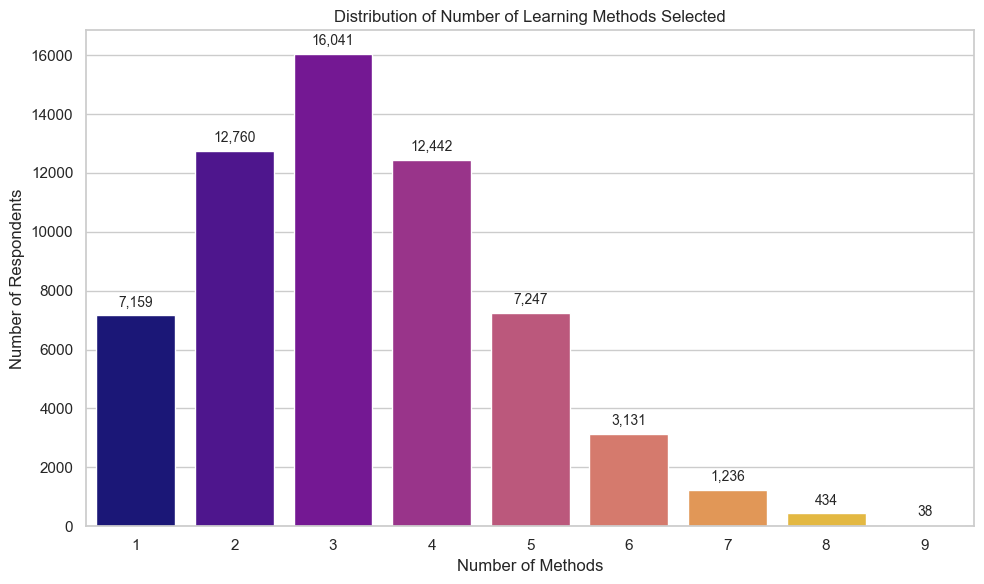

In [17]:
# Step 1: Count number of methods selected by each respondent
df_clean["NumMethods"] = df_clean["LearnCodeList"].apply(len)

# Step 2: Get the distribution (counts of each number)
num_methods_dist = df_clean["NumMethods"].value_counts().sort_index().reset_index()
num_methods_dist.columns = ['NumMethods', 'Count']

# Step 3: Plot with count labels
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='NumMethods', y='Count', data=num_methods_dist, hue = 'NumMethods', palette='plasma', legend=False)  # FIXED: define ax

# Add count labels on top of each bar
for i, row in num_methods_dist.iterrows():
    ax.text(i, row['Count'] + 300, f'{row["Count"]:,}', ha='center', fontsize=10)

plt.title('Distribution of Number of Learning Methods Selected')
plt.xlabel('Number of Methods')
plt.ylabel('Number of Respondents')
plt.tight_layout()
plt.show()


### Step 1.2: Most Common Learning Method Combinations

Next, we generate unique combinations of learning methods to understand:

- Which method bundles are most popular.
- Whether developers tend to rely on traditional (e.g., university + books) or more modern (e.g., online courses + videos) paths.

Each combination is sorted alphabetically to standardize grouping.


C:\Users\Admin\AppData\Local\Temp\ipykernel_21000\1840210917.py:22: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


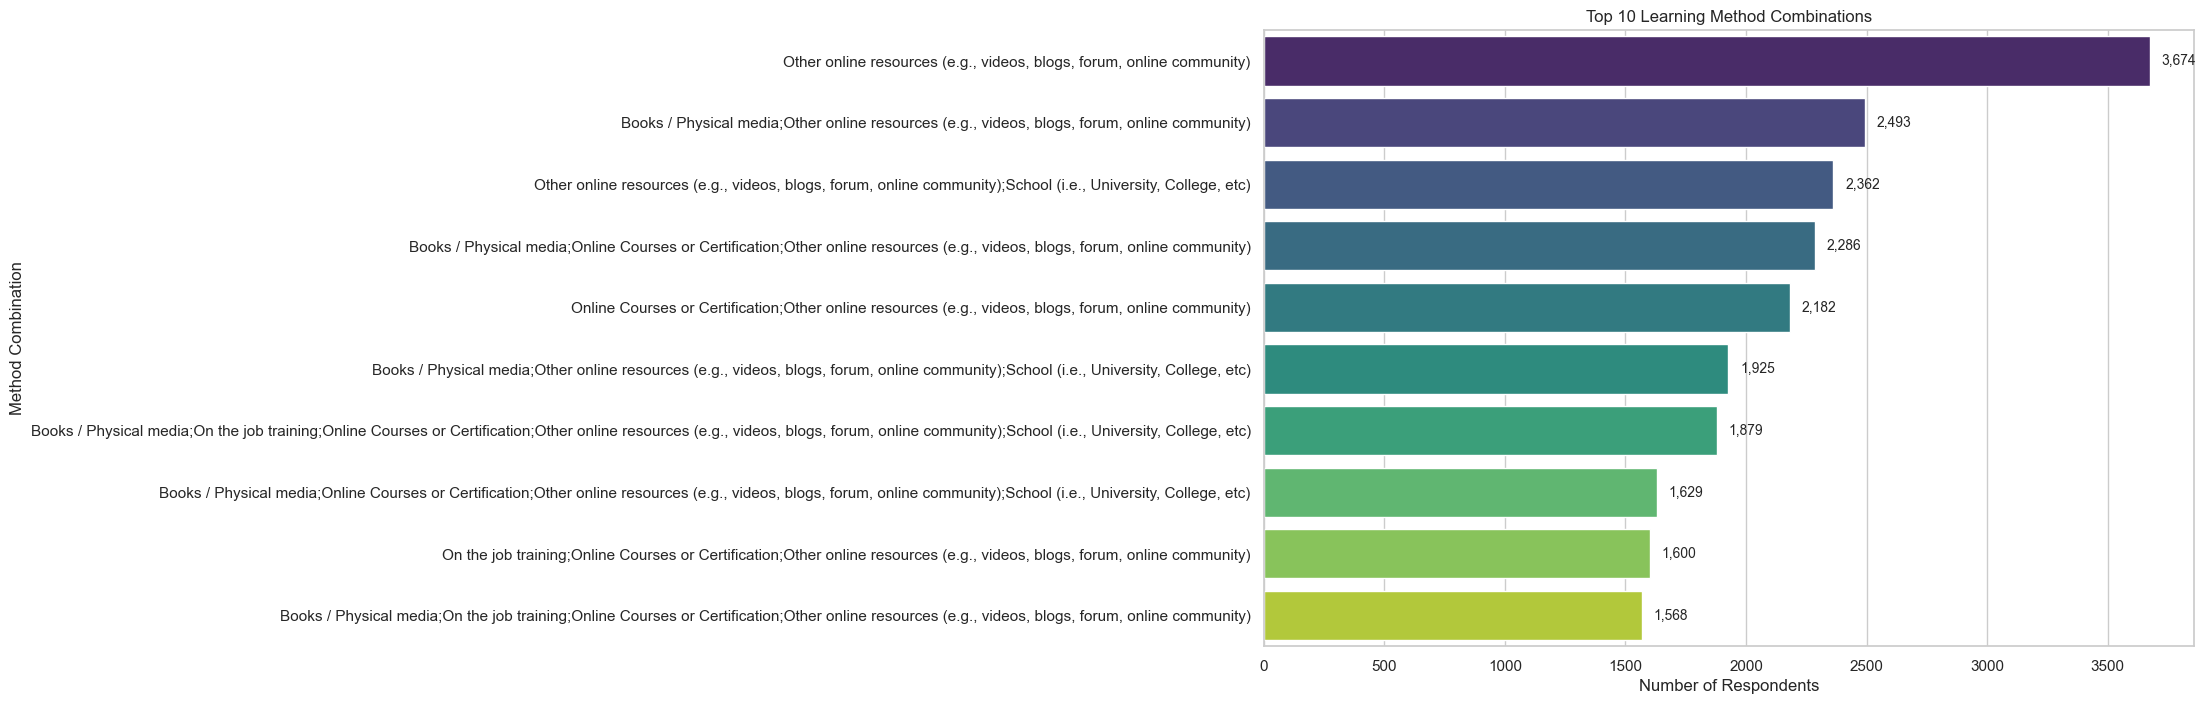

In [18]:
# Combine learning methods into sorted combo strings
df_clean["Combo"] = df_clean["LearnCodeList"].apply(lambda x: ";".join(sorted(x)))

# Count frequency of each combination
combo_counts = df_clean["Combo"].value_counts().head(10)

# Prepare for plotting
combo_df = combo_counts.reset_index()
combo_df.columns = ["Combo", "Count"]

# Plot with count labels
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Count', y='Combo', data=combo_df, hue = 'Combo', palette='viridis')

# Add count labels next to each bar
for i, row in combo_df.iterrows():
    ax.text(row["Count"] + 50, i, f'{row["Count"]:,}', va='center', fontsize=10)

plt.title('Top 10 Learning Method Combinations')
plt.xlabel('Number of Respondents')
plt.ylabel('Method Combination')
plt.tight_layout()
plt.show()


## Step 2: Most Popular Online Learning Resources

The `LearnCodeOnline` column lists the platforms and formats developers use to learn online (e.g., YouTube, documentation, MOOCs).

Here, we:
- Break responses into individual platforms.
- Count how many developers use each one.
- Calculate the average number of online resources used per person.

This reveals which online tools are most influential in developer learning today.


In [5]:
# Step 1: Clean and split LearnCodeOnline
df_clean_online = dev.dropna(subset=["LearnCodeOnline"]).copy()
df_clean_online["OnlineList"] = df_clean_online["LearnCodeOnline"].str.split(";").apply(lambda lst: [x.strip() for x in lst])

# Step 2: Total number of respondents who answered this question
total_respondents = df_clean_online.shape[0]

# Step 3: Flatten all online resource selections
all_resources = [resource for sublist in df_clean_online["OnlineList"] for resource in sublist]


# Step 4: Count frequency of each resource
resource_counts = pd.Series(all_resources).value_counts()
resource_percent = (resource_counts / total_respondents * 100).round(2)

# Step 5: Create summary table
resource_summary = pd.DataFrame({
    "Selected (%)": resource_percent,
    "Count": resource_counts
}).sort_values("Selected (%)", ascending=False)

# Step 6: Compute average number of online resources per respondent
df_clean_online["NumOnlineResources"] = df_clean_online["OnlineList"].apply(len)
avg_resources = df_clean_online["NumOnlineResources"].mean().round(2)

# Show results
print("📊 Most Popular Online Resources:")
display(resource_summary)

print(f"\n📈 Average number of online resource types per respondent: {avg_resources}")


📊 Most Popular Online Resources:


,Selected (%),Count
Technical documentation,83.81,41267
Stack Overflow,80.21,39492
Written Tutorials,68.37,33664
Blogs,61.35,30208
How-to videos,54.16,26668
Video-based Online Courses,49.93,24586
Books,46.49,22892
Social Media,41.17,20269
AI,37.06,18247
Written-based Online Courses,33.58,16535



📈 Average number of online resource types per respondent: 6.61


## Step 3: Learning Preferences by Age and Experience

Do learning preferences change as developers grow older or gain more experience?

In this section, we:
- Clean and bucket the `YearsCode` column into experience levels.
- Use age and experience groups to compare learning method usage.
- Visualize results using heatmaps to clearly show which methods are more or less popular across groups.

This helps us uncover generational and experiential trends in how developers learn.


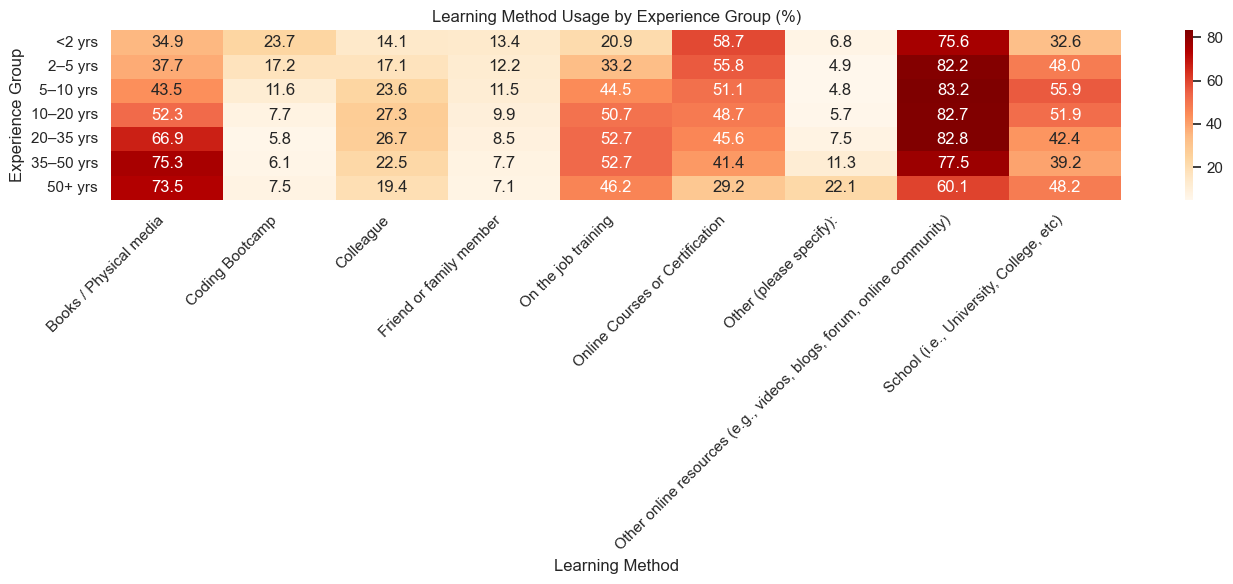

In [19]:
# Step 1: Clean YearsCode
def clean_years(val):
    if pd.isna(val):
        return None
    elif val == "Less than 1 year":
        return 0.5
    elif val == "More than 50 years":
        return 51
    else:
        try:
            return float(val)
        except:
            return None

df_clean["YearsCodeClean"] = df_clean["YearsCode"].apply(clean_years)

# Step 2: Bin YearsCode into experience groups
df_clean["ExpGroup"] = pd.cut(
    df_clean["YearsCodeClean"],
    bins=[0, 2, 5, 10, 20, 35, 50, 100],
    labels=["<2 yrs", "2–5 yrs", "5–10 yrs", "10–20 yrs", "20–35 yrs", "35–50 yrs", "50+ yrs"]
)

# Step 3: Merge with Experience groups only
df_analysis = pd.concat([df_clean[["ExpGroup"]], multi_hot], axis=1)

# Step 4: Cross-tab: ExpGroup × LearnCode method (%)
exp_method_pct = df_analysis.groupby("ExpGroup", observed= True)[mlb.classes_].mean().multiply(100).round(1)

# Step 5: Visualize heatmap for Experience Group
plt.figure(figsize=(14, 6))
sns.heatmap(exp_method_pct, annot=True, cmap="OrRd", fmt=".1f")
plt.title("Learning Method Usage by Experience Group (%)")
plt.ylabel("Experience Group")
plt.xlabel("Learning Method")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## Step 4: Do Learning Methods Influence Salary?

Now we investigate whether the way developers learn to code is associated with their reported salary — even after accounting for factors like education, region, and experience.

### Modeling Strategy:

We build two regression models using **log-transformed salary** as the outcome:

### Model 1: Learning Path (Macro-Level)

This model uses a broader classification of learning path — such as whether the respondent learned via:

- Formal
- Onjob
- Social
- Selfpaced

It helps us understand the **overall impact of learning strategy types**.

```python
log_salary ~ C(LearnPath) + C(EdLevel_clean) + YearsExp + C(Region) + C(Employment_simple)
```

### Model 2: Specific Learning Methods (Micro-Level)
This model zooms into the individual learning methods from the multi-hot encoded matrix — treating each method as a separate dummy variable (e.g., LC_Books, LC_YouTube, etc.).

```python
log_salary ~ LC_* + C(EdLevel_clean) + YearsExp + C(Region) + C(Employment_simple)
```
By comparing both models, we gain insight into both broad and granular effects, whether using specific tools or having a structured learning path has more influence on salary.


In [11]:
# ===========================================
# A. Imports & Config
# ===========================================
import numpy as np
import re

import statsmodels.formula.api as smf

# Display options
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)


# ===========================================
# B. Load Data & Select Columns
# ===========================================
PATH_TO_SURVEY = "survey_results_public.csv"  # <-- change this
df_raw = pd.read_csv(PATH_TO_SURVEY, low_memory=False) # tell python to process large data amount

# Core vars (check existence; drop missing safely)
core_cols = [
    "EdLevel", "LearnCode", "LearnCodeOnline", "YearsCode", "YearsCodePro",
    "DevType", "MainBranch", "ConvertedCompYearly", "Country", "Employment"
]
have_cols = [c for c in core_cols if c in df_raw.columns] # Get a new list have_cols that contains only the column names from core_cols that are actually present in df_raw
df = df_raw[have_cols].copy()

# Add respondent id if available; else create index id
if "Respondent" in df_raw.columns:
    df["RespondentID"] = df_raw["Respondent"]
else:
    df["RespondentID"] = np.arange(len(df))
# np.arange(len(df)): Creates an array like [0, 1, 2, ..., n-1] where n is the number of rows.

# ===========================================
# C. Helper: numeric cleaning
# ===========================================
def clean_years(series):
    """Convert YearsCode or YearsCodePro to numeric float."""
    if series is None:
        return None
    s = series.astype(str).str.strip()
    s = s.replace({
        "Less than 1 year": "0.5",
        "Less than 1 Year": "0.5",
        "More than 50 years": "50",
        "50+" : "50",
        "NA": np.nan,
        "nan": np.nan
    })
    # remove non-digit except dot
    s = s.str.extract(r"([\d\.]+)", expand=False)
    return pd.to_numeric(s, errors="coerce")


# YearsCodePro preferred; fallback to YearsCode
if "YearsCodePro" in df.columns:
    df["YearsExp"] = clean_years(df["YearsCodePro"])
else:
    df["YearsExp"] = clean_years(df["YearsCode"])


# ===========================================
# D. Clean Salary
# ===========================================
if "ConvertedCompYearly" in df.columns:
    df["Salary"] = pd.to_numeric(df["ConvertedCompYearly"], errors="coerce")
else:
    df["Salary"] = np.nan

# Drop impossible / non-positive
df.loc[df["Salary"] <= 0, "Salary"] = np.nan

# Winsorize to 1st–99th percentile to reduce outliers (optional)
sal_lo, sal_hi = df["Salary"].quantile([0.01, 0.99])
df["Salary_w"] = df["Salary"].clip(lower=sal_lo, upper=sal_hi)

# Log salary
df["log_salary"] = np.log(df["Salary_w"])


# ===========================================
# E. Clean EdLevel
# ===========================================
ed_map = {
    "Primary/elementary school": "Primary",
    "Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)": "Secondary",
    "Some college/university study without earning a degree": "SomeCollege",
    "Associate degree (A.A., A.S., etc.)": "Associate",
    "Bachelor’s degree (B.A., B.S., B.Eng., etc.)": "Bachelors",
    "Master’s degree (M.A., M.S., M.Eng., MBA, etc.)": "Masters",
    "Professional degree (JD, MD, Ph.D, Ed.D, etc.)": "Professional",
}
df["EdLevel_clean"] = df["EdLevel"].map(ed_map).fillna("Other")

# Binary tertiary (Associate+)
df["Has_Tertiary"] = df["EdLevel_clean"].isin(
    ["Associate", "Bachelors", "Masters", "Professional"]
).astype(int)


# ===========================================
# F. Parse LearnCode (multi-select) → canonical categories
# ===========================================
# Build regex-based mappings (order matters; more specific first)

LEARNCODE_CANON_MAP = {
    r"School|University|College": "School",
    r"Bootcamp": "Bootcamp",
    r"Online Courses|Certification": "OnlineCourse",
    r"Books|Physical media": "Books",
    r"Other online resources|videos|blogs|forum|community": "OtherOnline",
    r"On the job training": "OnJob",
    r"Colleague": "Colleague",
    r"Friend|family member": "Friend",
    r"Other \(please specify\)": "Other"
}

def parse_multiselect_col(series, canon_map, sep=";"):
    """
    Split series of semicolon-delimited strings into list of canonical tokens.
    Returns list-of-lists aligned with index.
    """
    out = []
    for val in series.fillna(""):
        if not val or pd.isna(val):
            out.append([])
            continue
        parts = [p.strip() for p in str(val).split(sep) if p.strip()]
        canon_tokens = []
        for p in parts:
            matched = False
            for pattern, target in canon_map.items():
                if re.search(pattern, p, flags=re.IGNORECASE):
                    canon_tokens.append(target)
                    matched = True
                    break
            if not matched:
                canon_tokens.append("Other")
        # deduplicate within respondent
        canon_tokens = sorted(set(canon_tokens))
        out.append(canon_tokens)
    return out

df["LearnCode_list"] = parse_multiselect_col(df["LearnCode"], LEARNCODE_CANON_MAP)

# Multi-hot DataFrame
unique_learn_methods = sorted({
    token for lst in df["LearnCode_list"] for token in lst if token
})
learncode_bools = pd.DataFrame(
    {m: df["LearnCode_list"].apply(lambda lst, m=m: int(m in lst)) for m in unique_learn_methods},
    index=df.index
) 
#Create a dataframe. With m in unique_learn_methods (9 unique values), for each list in each row, check if m have in there, then return 1 (true) and 0 (False)
#return a table, with 9 columns and over 60k rows of 0 and 1 value.

# Add prefix
learncode_bools = learncode_bools.add_prefix("LC_")

# Count methods
df["NumLearnMethods"] = learncode_bools.sum(axis=1) # axis = 1, sum horizontally for each response


# ===========================================
# G. Expanded Learning Path Classification (5 groups)
# ===========================================
formal_set = {"School", "Bootcamp"}
online_set = {"OnlineCourse", "OtherOnline"}
social_set = {"Colleague", "Friend"}
independent_set = {"Books"}
onjob_set = {"OnJob"}
other_set = {"Other"}

def classify_learning(lst):
    if not lst or lst is None:
        return "Missing"
    categories = set(lst)
    if categories & formal_set:
        return "Formal"
    elif categories & onjob_set:
        return "OnJob"
    elif categories & social_set:
        return "Social"
    elif categories & online_set or categories & independent_set:
        return "SelfPaced"
    elif categories & other_set:
        return "Other"
    else:
        return "Missing"

df["LearnPath"] = df["LearnCode_list"].apply(classify_learning)



# ===========================================
# H. Parse Employment
# ===========================================
# Employment may be multi-select; reduce to 4 types

def classify_employment(text):
    if pd.isna(text) or not str(text).strip():
        return "Unknown"
    t = str(text).lower().strip()
    if t == "i prefer not to say":
        return "Unknown"
    if "student" in t:
        return "Student"
    if "independent contractor" in t or "freelancer" in t or "self-employed" in t:
        return "Independent"
    if "full-time" in t:
        return "Full-time"
    if "part-time" in t:
        return "Part-time"
    return "Inactive"

df["Employment_simple"] = df["Employment"].apply(classify_employment)



# ===========================================
# I. Collapse Country to Region 
# ===========================================
#import warnings
#import country_converter as coco

# Initialize converter
#cc = coco.CountryConverter()


# Convert to continent names safely
#df['Region'] = df['Country'].apply(lambda x: cc.convert(names=x, to='continent') if isinstance(x, str) else 'Unknown')


import warnings
import country_converter as coco

# Initialize converter
cc = coco.CountryConverter()

# List of known invalid entries to exclude or assign manually
invalid_entries = ['Nomadic']

def safe_convert(country):
    if isinstance(country, str) and country not in invalid_entries:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            return cc.convert(names=country, to='continent')
    return 'Unknown'

# Apply to your real dataset without redefining df
df['Region'] = df['Country'].apply(safe_convert)


from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder

# ===========================================
# J. Build Analysis Frame (Modified)
# ===========================================

# Combine df with multi-hot learning methods
df_analysis = pd.concat([df, learncode_bools], axis=1)

# Drop rows where Region is 'Nomadic'
df_analysis = df_analysis[df_analysis["Region"] != "Nomadic"]

# Drop rows with missing values in columns that have <5% missing
missing_percent = df_analysis.isna().mean()
cols_below_5pct = missing_percent[missing_percent < 0.05].index.tolist()
df_analysis = df_analysis.dropna(subset=cols_below_5pct)

# Make a copy for encoding (temporary for imputation)
df_encoded = df_analysis.copy()

# Create mapping dictionaries for categorical variables
cat_cols = [col for col in ["EdLevel_clean", "Employment_simple", "Region", "LearnPath"] 
            if col in df_encoded.columns]

# Create and apply mappings (store originals)
for col in cat_cols:
    df_encoded[f"{col}_encoded"] = pd.factorize(df_analysis[col])[0]
    # Keep original column for later use
    df_encoded[col] = df_analysis[col]  

# -------------------------------------------
# Model-based Imputation for log_salary (using encoded values)
# -------------------------------------------
log_salary_features = [
    "YearsExp", 
    *[f"{col}_encoded" for col in ["EdLevel_clean", "Employment_simple", "Region", "LearnPath"]],
    "NumLearnMethods"
] + [col for col in df_encoded.columns if col.startswith("LC_")]

df_known_log_salary = df_encoded[df_encoded["log_salary"].notna()]
df_missing_log_salary = df_encoded[df_encoded["log_salary"].isna()]

rf_log = RandomForestRegressor(n_estimators=100, random_state=42)
rf_log.fit(df_known_log_salary[log_salary_features], df_known_log_salary["log_salary"])

predicted_log_salary = rf_log.predict(df_missing_log_salary[log_salary_features])
df_encoded.loc[df_encoded["log_salary"].isna(), "log_salary"] = predicted_log_salary

# -------------------------------------------
# Model-based Imputation for YearsExp (using encoded values)
# -------------------------------------------
years_exp_features = [
    "log_salary",
    *[f"{col}_encoded" for col in ["EdLevel_clean", "Employment_simple", "Region", "LearnPath"]],
    "NumLearnMethods"
] + [col for col in df_encoded.columns if col.startswith("LC_")]

df_known_exp = df_encoded[df_encoded["YearsExp"].notna()]
df_missing_exp = df_encoded[df_encoded["YearsExp"].isna()]

rf_exp = RandomForestRegressor(n_estimators=100, random_state=42)
rf_exp.fit(df_known_exp[years_exp_features], df_known_exp["YearsExp"])

predicted_exp = rf_exp.predict(df_missing_exp[years_exp_features])
df_encoded.loc[df_encoded["YearsExp"].isna(), "YearsExp"] = predicted_exp

# -------------------------------------------
# Prepare final dataset with original categorical values
# -------------------------------------------
df_model = df_encoded.copy()

# Drop the encoded columns (we don't need them anymore)
encoded_cols = [col for col in df_model.columns if col.endswith("_encoded")]
df_model = df_model.drop(columns=encoded_cols)

#run regressions with proper categorical names

predictor_cols = [
    "YearsExp", "EdLevel_clean", "Employment_simple", "Region", "LearnPath", "NumLearnMethods"
] + [col for col in df_model.columns if col.startswith("LC_")]

# Define LC columns (individual learning method dummies)
lc_cols = [col for col in df_model.columns if col.startswith("LC_")] 

# Now ready for model training
print(df_model[predictor_cols + ["log_salary"]].head())

# ===========================================
# L. Regression: log_salary ~ LearnCodeMethods + EdLevel + Years + Country/Region + Employment
# ===========================================
# Choose macro categories vs individual dummies:
# 1) Macro: LearnPath 
# 2) Micro: all LC_* dummies

# --- Model 1: Macro (easier to interpret)
df_model = df_model[df_model["LearnPath"] != "Missing"]


form1 = "log_salary ~ C(LearnPath) + C(EdLevel_clean) + YearsExp + C(Region) + C(Employment_simple)"
model1 = smf.ols(formula=form1, data=df_model).fit(cov_type="HC3")
print("\n=== OLS Model 1: Macro Learning Path ===")
print(model1.summary())


# --- Model 2: Micro (individual learning flags) ---
# Drop the reference category by excluding one dummy or letting patsy drop automatically.
lc_terms = " + ".join(lc_cols)  # these are 0/1

form2 = f"log_salary ~ {lc_terms} + C(EdLevel_clean) + YearsExp + C(Region) + C(Employment_simple)"
model2 = smf.ols(formula=form2, data=df_model).fit(cov_type="HC3")
print("\n=== OLS Model 2: Individual Learning Methods ===")
print(model2.summary())


# ===========================================
# M. Interpret % Effects
# For linear model on log_salary: % diff ≈ (exp(beta) - 1)*100
# We'll extract selected coefficients and compute %
# ===========================================
def coef_to_pct(model, filter_str=None):
    coefs = model.params.copy()
    if filter_str:
        coefs = coefs[coefs.index.str.contains(filter_str)]
    pct = (np.exp(coefs) - 1) * 100
    return pd.DataFrame({"coef": coefs, "pct_change": pct})

print("\n=== Approx % salary differences: LearnPath Coefs ===")
print(coef_to_pct(model1, filter_str="LearnPath"))
print(coef_to_pct(model2, filter_str="LC_"))

   YearsExp EdLevel_clean Employment_simple   Region  LearnPath  NumLearnMethods  LC_Books  LC_Bootcamp  LC_Colleague  \
0     9.275       Primary         Full-time  America  SelfPaced                1         1            0             0   
1    17.000     Bachelors         Full-time   Europe      OnJob                4         1            0             1   
2    27.000       Masters         Full-time   Europe     Formal                5         1            0             1   
3     2.600   SomeCollege           Student  America     Formal                3         0            0             0   
4     1.900     Secondary           Student   Europe  SelfPaced                1         0            0             0   

   LC_Friend  LC_OnJob  LC_OnlineCourse  LC_Other  LC_OtherOnline  LC_School  log_salary  
0          0         0                0         0               0          0   10.576281  
1          0         1                0         0               1          0   11.399841  


## Step 5: Hybrid vs. Single-Method Learning


Finally, we define a new variable based on the number of learning methods used:

- **SingleMethod**: Developers who used only one learning method.
- **Hybrid**: Developers who used two or more.

We run a regression to test whether hybrid learners tend to have higher salaries, while controlling for experience, education, employment type, and region.

This gives us a high-level view of whether combining different learning strategies provides a measurable advantage in compensation.


In [12]:


# Start from the imputed analysis dataframe
df = df_model.copy()

# Ensure LearnCode_list exists (should already be there from Step 5)
assert "LearnCode_list" in df.columns, "LearnCode_list missing - check Step 5 processing"

# Create Single vs Hybrid classification
def classify_single_or_hybrid(lst):
    """Classify learning approach as single method or hybrid."""
    if not isinstance(lst, list):  # Handle any non-list values
        return "Missing"
    if len(lst) == 1:
        return "SingleMethod"
    elif len(lst) > 1:
        return "Hybrid"
    return "Missing"

df["LearnScope"] = df["LearnCode_list"].apply(classify_single_or_hybrid)
df["NumLearnMethods"] = df["LearnCode_list"].apply(lambda x: len(x) if isinstance(x, list) else 0)


# Prepare model data 
# Filter to valid cases 
model_df = df[
    (df["LearnScope"].isin(["SingleMethod", "Hybrid"])) &
    (df["Employment_simple"] != "Unknown")
].copy()

# Regression formula 
formula = (
    "log_salary ~ C(LearnScope, Treatment('SingleMethod')) + "
    "C(EdLevel_clean) + YearsExp + C(Region) + C(Employment_simple)"
)

print("\n=== OLS Regression: Hybrid vs SingleMethod ===")
model = smf.ols(formula=formula, data=model_df).fit(cov_type="HC3")
print(model.summary())

# Salary % difference
print("\n=== Approx % Salary Differences ===")
print(coef_to_pct(model, filter_str="LearnScope"))



=== OLS Regression: Hybrid vs SingleMethod ===
                            OLS Regression Results                            
Dep. Variable:             log_salary   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     3567.
Date:                Mon, 28 Jul 2025   Prob (F-statistic):               0.00
Time:                        21:19:44   Log-Likelihood:                -76834.
No. Observations:               60036   AIC:                         1.537e+05
Df Residuals:                   60017   BIC:                         1.539e+05
Df Model:                          18                                         
Covariance Type:                  HC3                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------